Data source: https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377
resume situation: A distribution company that was recently a victim of fraud has completed an audit of various samples of wine through the use of chemical analysis on samples. The distribution company specializes in exporting extremely high quality, expensive wines, but was defrauded by a supplier who was attempting to pass off cheap, low quality wine as higher grade wine. The distribution company has hired you to attempt to create a machine learning model that can help detect low quality (a.k.a "fraud") wine samples. They want to know if it is even possible to detect such a difference.

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [74]:
df = pd.read_csv("wine_fraud.csv")

In [75]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


//////////////////////////////////////////////////////////////////////////////

In [76]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

<AxesSubplot:xlabel='type', ylabel='count'>

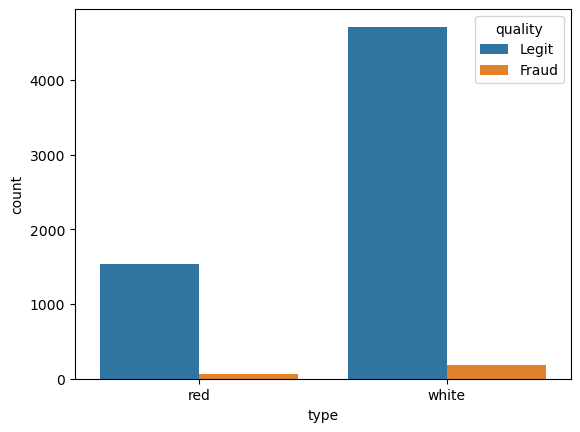

In [77]:
sns.countplot(x='type',hue='quality', data=df)

In [78]:
reds = df[df["type"]=='red']
whites = df[df["type"]=='white']

print("Percentage of fraud in Red Wines:")
print(100* (len(reds[reds['quality']=='Fraud'])/len(reds)))

print('\n')

print("Percentage of fraud in White Wines:")
print(100* (len(whites[whites['quality']=='Fraud'])/len(whites)))

Percentage of fraud in Red Wines:
3.9399624765478425


Percentage of fraud in White Wines:
3.7362188648427925


In [79]:
df['Fraud']= df['quality'].map({'Legit':0,'Fraud':1})

df.drop(['quality'], axis=1, inplace=True)

In [80]:
df['type'] = pd.get_dummies(df['type'], drop_first=True)

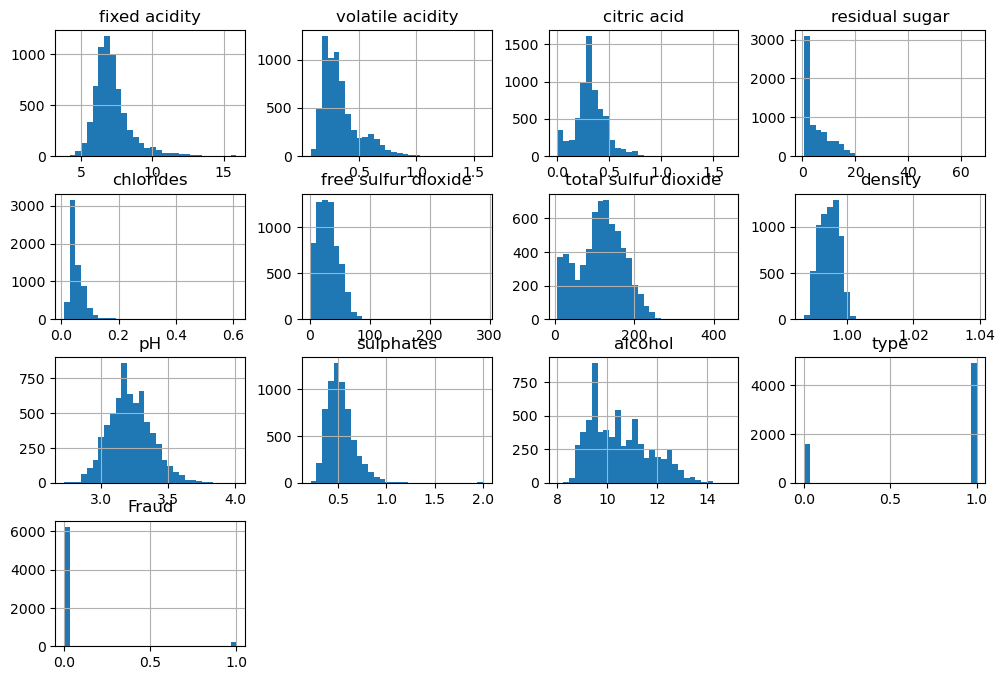

In [81]:
df.hist(figsize=(12, 8), bins=30)
plt.show()

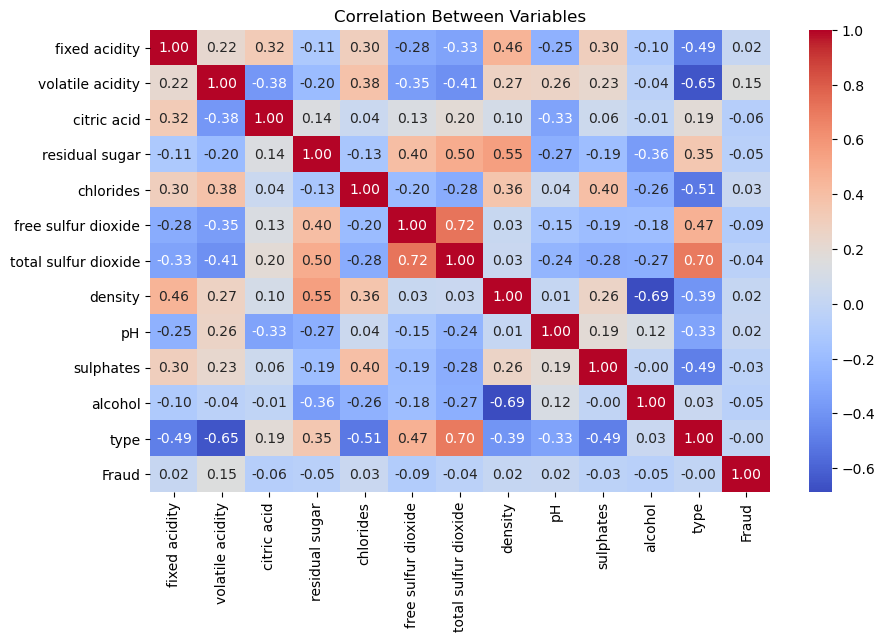

In [82]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Variables")
plt.show()

//////////////////////////////////////////////////////////////////////////////////////////////////////////

ML Part

In [83]:
X = df.drop('Fraud',axis=1)
y = df['Fraud']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

///////////////////////////////////////////////////////////////////////////////////////

In [85]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

///////////////////////////////////////////////////////////////////////////////////////

In [86]:
svc = SVC(class_weight='balanced')

///////////////////////////////////////////////////////////////////////////////////////

In [87]:
param_grid = {
              'C': np.logspace(-3,2,10),
              'gamma':['scale','auto'] + list(np.logspace(-3,2,10))
             }

In [88]:
random_search = RandomizedSearchCV(SVC(class_weight='balanced'), param_grid, n_iter=20, cv=5, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_iter=20,
                   param_distributions={'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                        'gamma': ['scale', 'auto', 0.001,
                                                  0.003593813663804626,
                                                  0.01291549665014884,
                                                  0.046415888336127795,
                                                  0.1668100537200059,
                                                  0.5994842503189409,
                                                  2.1544346900318843,
                                                  7.742636826811277,
                                                  27.825594022071257, 100.0]},
                   random_state=42)

In [89]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Parameters:", random_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'gamma': 100.0, 'C': 27.825594022071257}

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       625
           1       1.00      0.04      0.08        25

    accuracy                           0.96       650
   macro avg       0.98      0.52      0.53       650
weighted avg       0.96      0.96      0.95       650



////////////////////////////////////////////////////////////////////////////////////////////////

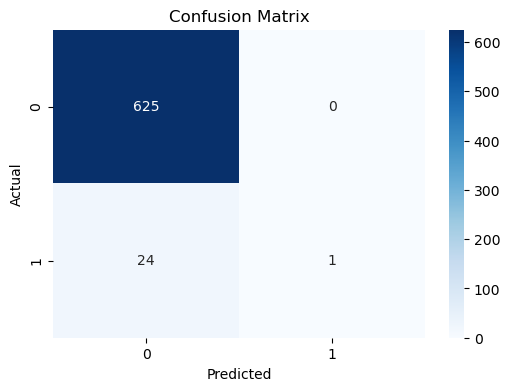

In [90]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

////////////////////////////////////////////////////////////////////////////////////

In [91]:
y_scores = best_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

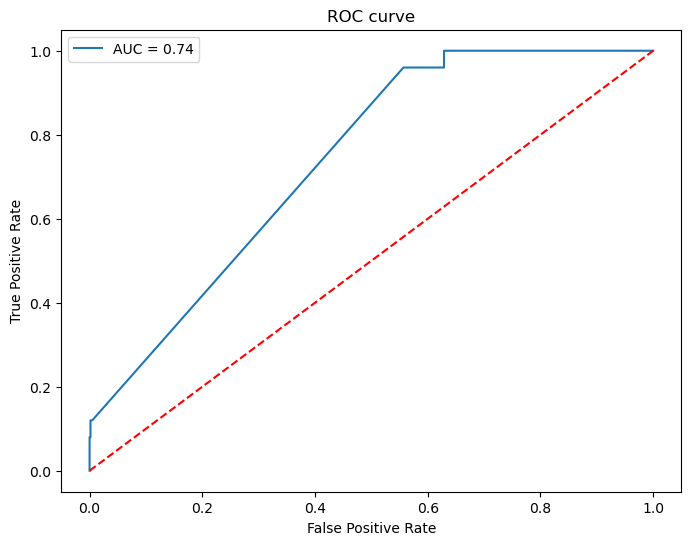

In [92]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

//////////////////////////////////////////////////////////////////////////////

In [93]:
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

print('\n')

print("Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in training set:
0    0.962203
1    0.037797
Name: Fraud, dtype: float64


Class distribution in test set:
0    0.961538
1    0.038462
Name: Fraud, dtype: float64


In [94]:
print("\nFull Classification Report:")
print(classification_report(y_test, y_pred))


Full Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       625
           1       1.00      0.04      0.08        25

    accuracy                           0.96       650
   macro avg       0.98      0.52      0.53       650
weighted avg       0.96      0.96      0.95       650

